# Pilot for Pyswarms

In [11]:
import matplotlib.pyplot as plt, pandas as pd, numpy as np
from cerebrum_0130 import utils, datainsights as di
from collections import namedtuple
import math 
from pyswarm import pso

### Get Input

In [7]:
df = pd.read_csv('data/pyswarms_sample_1.csv')
print('DATA:')
print('Shape:', df.shape)
print('Columns:', df.columns.to_list())
print('-'*100)

DATA:
Shape: (30, 19)
Columns: ['i', 'e', 'g', 'cos_g', 'w', 'b', 'c', 'cos_i', 'cos_e', 'p_g', 'K', 'gamma', 'r0', 'cos_i_k', 'cos_e_k', 'h_mu_0', 'h_mu', 'refl', 'wave']
----------------------------------------------------------------------------------------------------


In [8]:
def check_dq(df, dq_insights_file):
    #Add hash
    df = utils.add_hash(df, 'key')

    # DQ Validation:
    dqp = di.get_data_quality(df,dq_insights_file)

    n_wave = df.wave.to_numpy()
    n_refl = df.refl.to_numpy()
    i_array = df.i.to_numpy()
    e_array = df.e.to_numpy()
    g_array = df.g.to_numpy()
    min_wave, max_wave = n_wave.min(), n_wave.max()

    return df, dqp, n_wave, n_refl, i_array, e_array, g_array, min_wave, max_wave

In [9]:
dq_insights_file = 'cerebrum_0130/dq_insights.csv'
df, dqp, n_wave, n_refl, i_array, e_array, g_array, min_wave, max_wave = check_dq(df, dq_insights_file)


#### Show Data Insights

Workspace Data
````````````````````````````````````````````````````````````````````````````````````````````````````
        var         |       value        |        min         |        max         
        wave        |         30         |        0.7         |        0.7         
        refl        |         30         |        0.12        |        0.19        
      i_unique      |         6          |         45         |         70         
      e_unique      |         25         |        -85         |         43         
      g_unique      |         30         |         2          |        155         
----------------------------------------------------------------------------------------------------
Data Quality
````````````````````````````````````````````````````````````````````````````````````````````````````
                                   Info                                    |                      Result                      
                      Data Quality on 

<AxesSubplot:xlabel='wave(nm)', ylabel='refl'>

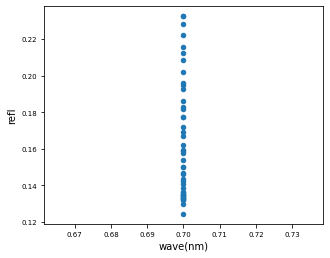

In [19]:
wsdata = []
itable = namedtuple('itable',['var','value','min','max'])
wsdata.append(itable('wave',  n_wave.shape[0], round(min_wave,2), round(max_wave,2)))
wsdata.append(itable('refl',  n_refl.shape[0], round(n_refl.min(),2), round(n_refl.max(),2)))
wsdata.append(itable('i_unique',  int(dqp['i_count']), int(round(i_array.min(),2)), int(round(i_array.max(),2))))
wsdata.append(itable('e_unique',  int(dqp['e_count']), int(round(e_array.min(),2)), int(round(e_array.max(),2))))
wsdata.append(itable('g_unique',  int(dqp['g_count']), int(round(g_array.min(),2)), int(round(g_array.max(),2))))

dq = namedtuple('dq',['info','result'])
dq_results = []
dq_results.append(dq('Data Quality on Wave(nm) - wave', dqp['wave_scenario']))
dq_results.append(dq('Data Quality on Incident Angle(deg) - i', dqp['incident_angle_scenario']))
dq_results.append(dq('Data Quality on Emission Angle(deg) - e', dqp['emmission_angle_scenario']))
dq_results.append(dq('Data Quality on Phase Angle(deg) - g', dqp['phase_angle_scenario']))
dq_results.append(dq('Data Quality on Opp. Surge', dqp['opp_surge_scenario']))
dq_results.append(dq('Data Quality on Shadow Hiding - Bs', dqp['ext_bs_scenario']))
dq_results.append(dq('Data Quality on Coherence Ratio - Bc', dqp['ext_coh_ratio_scenario']))
dq_results.append(dq('Data Quality on Phase Angle Coverage (Need more than 27 percent filled)', dqp['g_covg']))
dq_results.append(dq('Preprocess: Can crop?', dqp['scene'].pp_crop.values[0]))
dq_results.append(dq('Total Unique i,e,g combinations', dqp['all_angles_cnt']))
dq_results.append(dq('Data Process Satus Reccommendation', dqp['process_status']))

print('='*100)
print('Workspace Data')
print('`'*100)
row = "{name1:^20}|{name2:^20}|{name3:^20}|{name4:^20}".format
print(row(name1='var', name2='value', name3='min', name4='max'))
for tup in wsdata:
    print(row(name1=tup[0], name2=tup[1], name3=tup[2],name4=tup[3]))
print('-'*100)
print('Data Quality')
print('`'*100)
row = "{name1:^75}|{name2:^50}".format
print(row(name1='Info', name2='Result'))
for tup in dq_results:
    print(row(name1=tup[0], name2=tup[1]))
print('='*100)

df.plot('wave', 'refl','scatter',figsize=(5,4), fontsize=7, xlabel='wave(nm)')


### Calculate Model Reflectance

- Need all variables
- Missing Bc0, Bs0
- To calculate Bc, Bs - need hc, hs
- Need interpretation of below: what is Dmin, Dmax or is it any other surface
- hs = (3 * (3**1/2)/8) * ((PoreK * ff)/np.log(D_min/D_mx)
- in any other surface:: hs = (3* PoreK * ff / 8)

- What are the vars in path
- hc = (lamda / 4 * math.pi * path)
- path = [PoreK*N*σ*QS(1−ξ)]−1
- path = (2/3)(D/(PoreK*ff*Qs(1-ξ)))